# Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Read DF

In [8]:
babies_df = pd.read_csv('https://drive.google.com/uc?id=145n4_o1g5ZMrnV_DZt8tR9rjZLlJvU5K')
babies_df.head(5)

,case,bwt,gestation,parity,age,height,weight,smoke
0,1,120,284.0,0,27.0,62.0,100.0,0.0
1,2,113,282.0,0,33.0,64.0,135.0,0.0
2,3,128,279.0,0,28.0,64.0,115.0,1.0
3,4,123,NaN,0,36.0,69.0,190.0,0.0
4,5,108,282.0,0,23.0,67.0,125.0,1.0


# Data prep and EDA

In [10]:
# Fill missing values with median
numeric_columns = babies_df.select_dtypes(include=['float64', 'int64']).columns
babies_df[numeric_columns] = babies_df[numeric_columns].apply(lambda x: x.fillna(x.median()))

In [12]:
excluded_columns = ('case', 'smoke', 'parity') 
for col in babies_df.columns.difference(excluded_columns):
    print(f'\nStatistical Summary for {col}: \n{babies_df[col].describe()}')



Statistical Summary for age: 
count    1236.000000
mean       27.253236
std         5.776943
min        15.000000
25%        23.000000
50%        26.000000
75%        31.000000
max        45.000000
Name: age, dtype: float64

Statistical Summary for bwt: 
count    1236.000000
mean      119.576861
std        18.236452
min        55.000000
25%       108.750000
50%       120.000000
75%       131.000000
max       176.000000
Name: bwt, dtype: float64

Statistical Summary for gestation: 
count    1236.000000
mean      279.345469
std        15.943257
min       148.000000
25%       272.000000
50%       280.000000
75%       288.000000
max       353.000000
Name: gestation, dtype: float64

Statistical Summary for height: 
count    1236.000000
mean       64.046926
std         2.510751
min        53.000000
25%        62.000000
50%        64.000000
75%        66.000000
max        72.000000
Name: height, dtype: float64

Statistical Summary for weight: 
count    1236.000000
mean      128.520227
std   

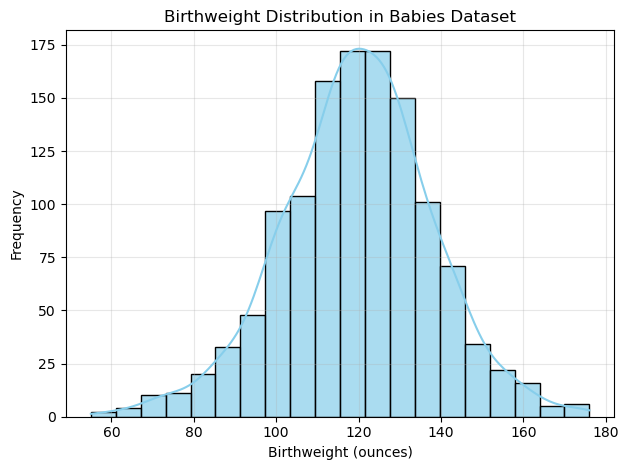

In [14]:
sns.histplot(babies_df['bwt'], bins=20, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Birthweight Distribution in Babies Dataset')
plt.xlabel('Birthweight (ounces)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Selecting Features

In [16]:
babies_df.columns.unique()

Index(['case', 'bwt', 'gestation', 'parity', 'age', 'height', 'weight',
       'smoke'],
      dtype='object')

In [18]:
excluded_columns = ('case', 'bwt')
print('Correlation and P tests between feature and bwt:')
for col in babies_df.columns.difference(excluded_columns):
    correlation = babies_df[col].corr(babies_df['bwt'], method='pearson')
    print(f'\nFeature: {col}')
    print(f'Correlation coefficient between {col} and birthweight: {correlation:.2f}')

Correlation and P tests between feature and bwt:

Feature: age
Correlation coefficient between age and birthweight: 0.03

Feature: gestation
Correlation coefficient between gestation and birthweight: 0.41

Feature: height
Correlation coefficient between height and birthweight: 0.20

Feature: parity
Correlation coefficient between parity and birthweight: -0.05

Feature: smoke
Correlation coefficient between smoke and birthweight: -0.24

Feature: weight
Correlation coefficient between weight and birthweight: 0.15


# Partition Data

In [20]:
# Isolate relevant features and target variable
features = babies_df.drop(columns=['case', 'bwt', 'parity', 'age'])
target = babies_df['bwt']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [22]:
# Encode the training set with dummy variables
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# Encode the test set with dummy variables
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align the test set columns with the training set columns by adding missing columns and filling with 0
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Develop Model

In [24]:
# Initialize and train the Random Forest regressor
rf_regressor = RandomForestRegressor(random_state=42)  # Using a regressor for predicting a continuous value (bwt)
rf_regressor.fit(X_train_encoded, y_train)

# Generate predictions for birthweight (bwt)
bwt_predictions = rf_regressor.predict(X_test_encoded)

# Evaluate Model

In [26]:
# Calculate and display the Root Mean Squared Error (RMSE) for prediction accuracy
rmse = round(np.sqrt(mean_squared_error(y_test, bwt_predictions)), 2)
print(f"Root Mean Squared Error: {rmse} ounces")

# Calculate and display the model's R-squared score
r_squared = round(rf_regressor.score(X_test_encoded, y_test), 2)
print(f"Model Score (R-squared): {r_squared}")

Root Mean Squared Error: 17.71 ounces
Model Score (R-squared): 0.2


In [28]:
babies_df['bwt'].describe()

count    1236.000000
mean      119.576861
std        18.236452
min        55.000000
25%       108.750000
50%       120.000000
75%       131.000000
max       176.000000
Name: bwt, dtype: float64

# Tune

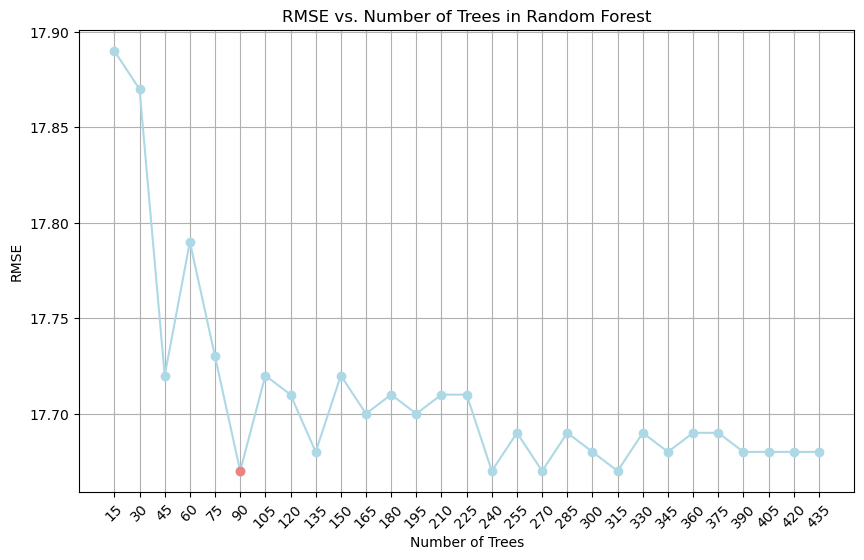

Best Number of Trees: 90, with RMSE: 17.67


In [30]:
# Initialize a list to store RMSE results for each estimator count
rmse_results = []

# Define the range of n_estimators to test (15 to 450 with step size 15)
n_estimators_range = range(15, 450, 15)

# Loop through the different values of n_estimators
for n in n_estimators_range:
    # Initialize and train the model with n_estimators
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    model.fit(X_train_encoded, y_train)
    
    # Predict and calculate RMSE
    y_pred = model.predict(X_test_encoded)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
    rmse_results.append(rmse)

# Identify the best number of estimators that minimizes RMSE
optimal_n_estimators = n_estimators_range[rmse_results.index(min(rmse_results))]

# Plot RMSE vs. Number of Trees
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, rmse_results, marker='o', linestyle='-', color='lightblue')
plt.plot(optimal_n_estimators, min(rmse_results), marker='o', linestyle='-', color='lightcoral')  # Best point in red
plt.title('RMSE vs. Number of Trees in Random Forest')
plt.xlabel('Number of Trees')
plt.xticks(n_estimators_range, rotation=45)
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

print(f"Best Number of Trees: {optimal_n_estimators}, with RMSE: {min(rmse_results)}")


# Redo model with KNN 

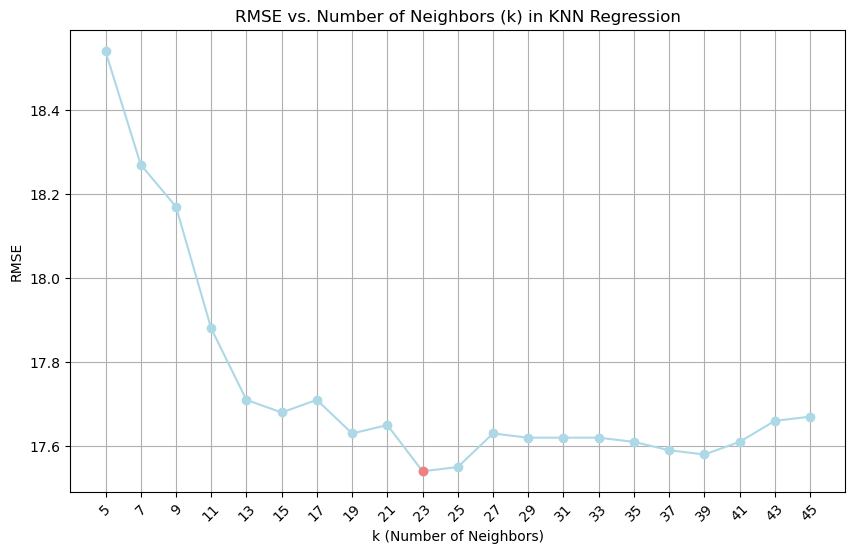

Best k value: 23, with RMSE: 17.54


In [32]:
# KNN Model 

# Initialize a list to store RMSE results for each k value
knn_rmse_results = []

# Define the range of odd k values to test (from 5 to 45)
k_values = list(range(5, 46, 2))

# Loop through each k value to evaluate the KNN model
for k in k_values:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train_encoded, y_train)
    
    # Predict and calculate RMSE
    y_pred = knn_model.predict(X_test_encoded)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
    knn_rmse_results.append(rmse)

# Find the best k value that minimizes RMSE
best_k_value = k_values[knn_rmse_results.index(min(knn_rmse_results))]

# Plot RMSE vs. k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_rmse_results, marker='o', linestyle='-', color='lightblue')
plt.plot(best_k_value, min(knn_rmse_results), marker='o', linestyle='-', color='lightcoral')  # Highlight best k in red
plt.title('RMSE vs. Number of Neighbors (k) in KNN Regression')
plt.xlabel('k (Number of Neighbors)')
plt.xticks(k_values, rotation=45)
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

print(f"Best k value: {best_k_value}, with RMSE: {min(knn_rmse_results):.2f}")

# Feature Importance

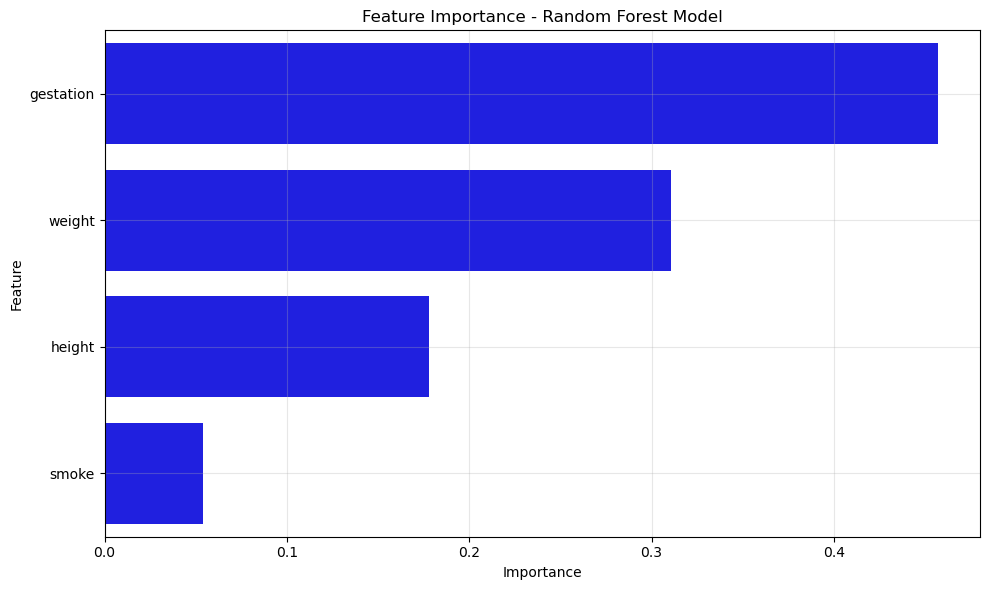

In [34]:
importance = rf_regressor.feature_importances_

# Get feature names from the dataset
feature_names = X_train.columns

# Create a DataFrame with feature names and importance values
important_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

important_df = important_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=important_df, color='blue')
plt.title('Feature Importance - Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(alpha=0.3, zorder=0)
plt.tight_layout()
plt.show()